<a href="https://colab.research.google.com/github/tankalasaiambica/Item-Demand-Forecasting-LightGBM/blob/main/Item_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Item Demand Forecasting Using Light Gradient Boosting Machine 




# Importing required libraries

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import lightgbm as lgb
import datetime
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score

In [82]:
# reading the dataset
data = pd.read_csv("/content/drive/MyDrive/train 2.csv")

# EDA for verfication of data

In [83]:
data.head() # first five rows

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [84]:
data.tail() # last five rows

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [85]:
print("data of the dataset :",data.shape) 

data of the dataset : (913000, 4)


In [86]:
print("empty values in dataset :","\n",data.isnull().sum())

empty values in dataset : 
 date     0
store    0
item     0
sales    0
dtype: int64


In [87]:
print("null values in dataset :",data.isna().sum())

null values in dataset : date     0
store    0
item     0
sales    0
dtype: int64


In [88]:
# describe for only items and sales
data[['item','sales']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


In [89]:
data["date"].min(), data["date"].max()   # printing max and min of dates in dataset

('2013-01-01', '2017-12-31')

In [90]:
data['item'].unique() # printing unique values in item column

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [91]:
data["store"].unique() # printing unique values in store column

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [92]:
# printing How many items are in the each store
data.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

[Text(0.5, 1.0, 'sales distrubtion')]

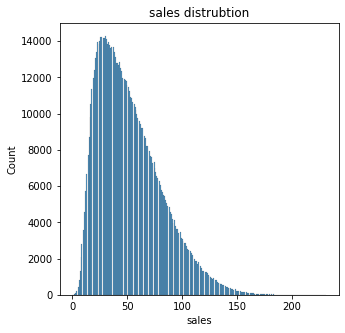

In [93]:
sns.histplot(data=data, x="sales").set(title='sales distrubtion') # ploting distrubtion of the sales column using historgram

In [94]:
data.info() # information of the dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [95]:
data['date'] = pd.to_datetime(data['date']) # by using pd.datetime we are converting the date column to datetime64[]

In [96]:
data.dtypes # checking again if date datatype is changed or not

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

# Feature Engineering

In [97]:
data['day'] = data['date'].dt.dayofweek # which day of the week among 1-7 days

data['week_of_year'] =data['date'].dt.weekofyear # which week of the year

data['month'] = data['date'].dt.month # month column

data['quarter'] = data['date'].dt.quarter # year quarter

data['year'] = data['date'].dt.year # year column

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


# Data Visualisation

[Text(0.5, 1.0, 'day vs sales')]

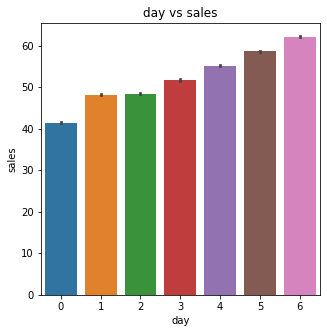

In [98]:
sns.barplot(data=data, x="day", y="sales").set(title='day vs sales')

from weekly days analysis we can say that at the start of the week the sales are less it is may be bescaue of the working days and increase at the weekends saturday and sunday so we can say that there is more sales at week ends

[Text(0.5, 1.0, 'year vs sales growth')]

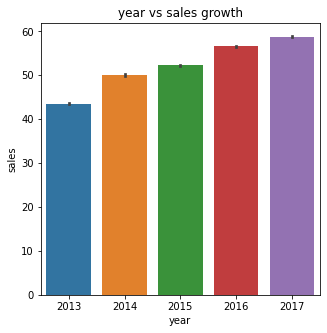

In [99]:
sns.barplot(data=data, x="year", y="sales").set(title='year vs sales growth') # barplot between year and sales to check whether there is a trend in the sales or not

From above yearly wise there is a gradual increase in the sales by that we can say that the for coming years also sales rate will be high


[Text(0.5, 1.0, 'month vs sales growth')]

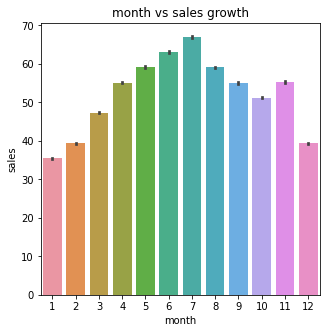

In [100]:
sns.barplot(data=data, x="month", y="sales").set(title='month vs sales growth') # barplot between month and sales to check whether there is a trend in the sales or not

From above barplot we can see that there is a seasonal trend in the sales of the item

In [101]:
# sns.barplot( x='quarter', y='sales', data= data).set(title= 'barplot to analysis quarter vs sales ')

[Text(0.5, 1.0, 'quarter vs sales ')]

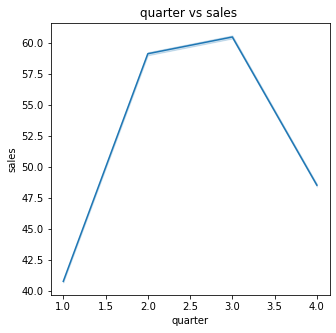

In [102]:
sns.lineplot(data=data, x="quarter", y="sales").set(title= 'quarter vs sales ')

From above we can say that at initial there is less sales in q1 and  increase in from q2 to q3 and decrease in Q4


[Text(0.5, 1.0, 'week_of_year vs sales')]

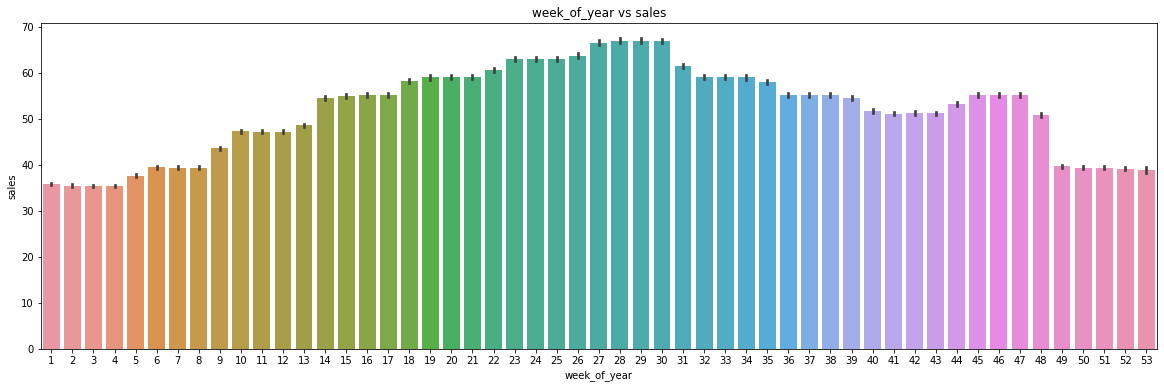

In [103]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=data, x="week_of_year", y="sales").set(title='week_of_year vs sales')

There is a increase trend upto 30 weeks after that there is a decrease in trend and again increase at 45-47 may be due to any event and decrease at the last four weeks means last month

In [104]:
""" here we are aggregating the sum of the sales for each item to see which item is having high sales rate """

items = data.groupby(["item"]).agg({  "sales"   : "sum"}).reset_index()
items = items.sort_values(by='sales',ascending=False)
items.head(10)

,item,sales
14,15,1607442
27,28,1604713
12,13,1539621
17,18,1538876
24,25,1473334
44,45,1471467
37,38,1470330
21,22,1469971
35,36,1406548
7,8,1405108


[Text(0.5, 1.0, 'items vs sales')]

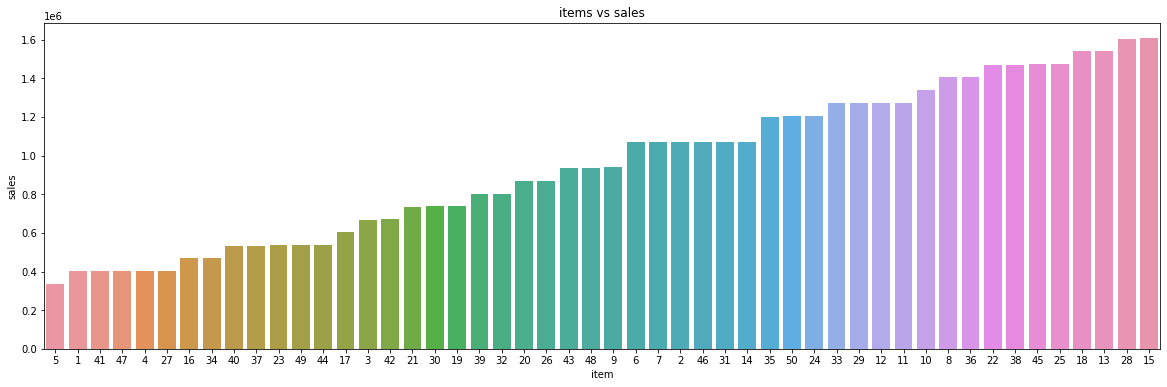

In [105]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=items, x="item", y="sales",order=items.sort_values('sales').item).set(title='items vs sales')

From here we can see that the mostly sold item is 15 and minimum sold item is 5

In [106]:
""" here we are aggregating the the sales by sum based on quarter and item  """
new_data = data.groupby(['quarter','item']).agg({  "sales"   : "sum"}).reset_index()

In [107]:
new_data.head()

,quarter,item,sales
0,1,1,76872
1,1,2,206930
2,1,3,128579
3,1,4,76915
4,1,5,64575


[Text(0.5, 1.0, 'Each items quarterly sales')]

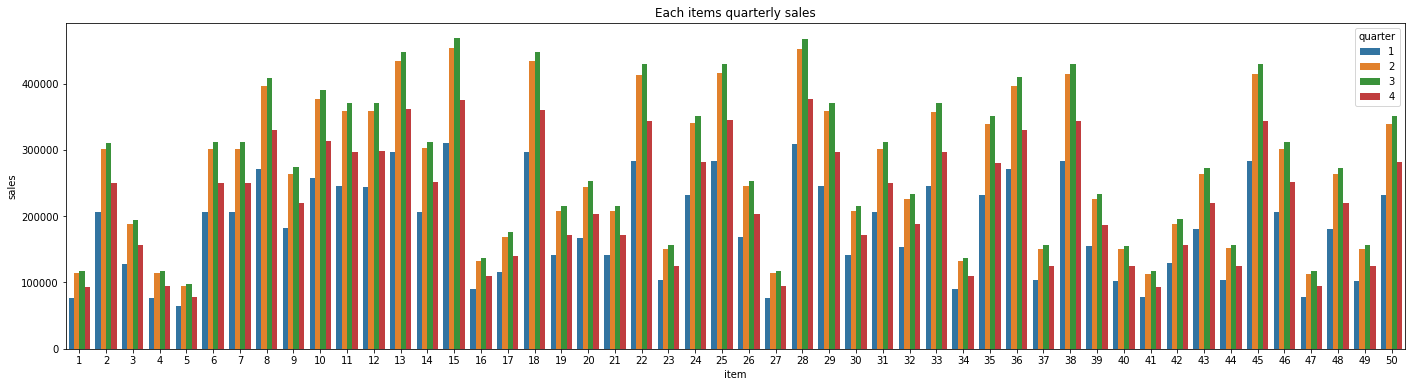

In [108]:
# here we are ploting the quarterly wise each item sales 
fig, ax = plt.subplots(figsize=(24, 6))
sns.barplot(data = new_data,x = 'item' ,y = 'sales',hue = 'quarter' ).set(title='Each items quarterly sales')

From above we can see that they in quarter one and four item is having less sales compared with the quarter two and three and there is high sales of each item in quarter three

In [109]:
# creating the new groupby dataframe series by grouping the item by date wise and aggregating sum of the sales
data_week = data.groupby(['item','date'])['sales'].sum()

In [110]:
data_week # group by data

item  date      
1     2013-01-01    133
      2013-01-02     99
      2013-01-03    127
      2013-01-04    145
      2013-01-05    149
                   ... 
50    2017-12-27    511
      2017-12-28    587
      2017-12-29    596
      2017-12-30    612
      2017-12-31    626
Name: sales, Length: 91300, dtype: int64

in the below function using the data_week we are adding the each date 90 days  in weekly base and taking the sum of the sales of each item  in that period and appending it in weekly _sales

In [111]:
weekly_sales = []
for item in range(1,51):
  ts = pd.Timestamp('2013-01-01')
  while(ts <= pd.Timestamp("2017-10-3")):
    d4 = dict()
    d4['item'] = item
    d4['date'] = ts
    d4['weekly_sales'] = data_week.loc[item, ts:ts+pd.DateOffset(days = 90)].sum()
    weekly_sales.append(d4)
    ts +=pd.DateOffset(days = 7)

In [112]:
df_week = pd.DataFrame(weekly_sales) # creating the dataframe by converting the weekly_sales  

In [113]:
df_week # printing dataframe

,item,date,weekly_sales
0,1,2013-01-01,12981
1,1,2013-01-08,13542
2,1,2013-01-15,14030
3,1,2013-01-22,14500
4,1,2013-01-29,15003
...,...,...,...
12445,50,2017-09-05,68007
12446,50,2017-09-12,66445
12447,50,2017-09-19,64902
12448,50,2017-09-26,63360


In [114]:
df_week['year'] = df_week['date'].dt.year # year column

df_week['day'] = df_week['date'].dt.day # day of the month  column

df_week['quarter'] = df_week['date'].dt.quarter # quarter of the year column

df_week['month'] = df_week['date'].dt.month # month column

In [115]:
df_week['weekly_sales'].describe()

count     12450.000000
mean      48016.090201
std       21661.154373
min       10761.000000
25%       29166.000000
50%       46334.000000
75%       63629.000000
max      108887.000000
Name: weekly_sales, dtype: float64

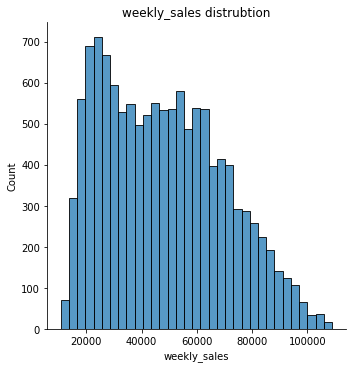

In [116]:
sns.displot(df_week["weekly_sales"]).set(title='weekly_sales distrubtion')   # ploting the weekly sales

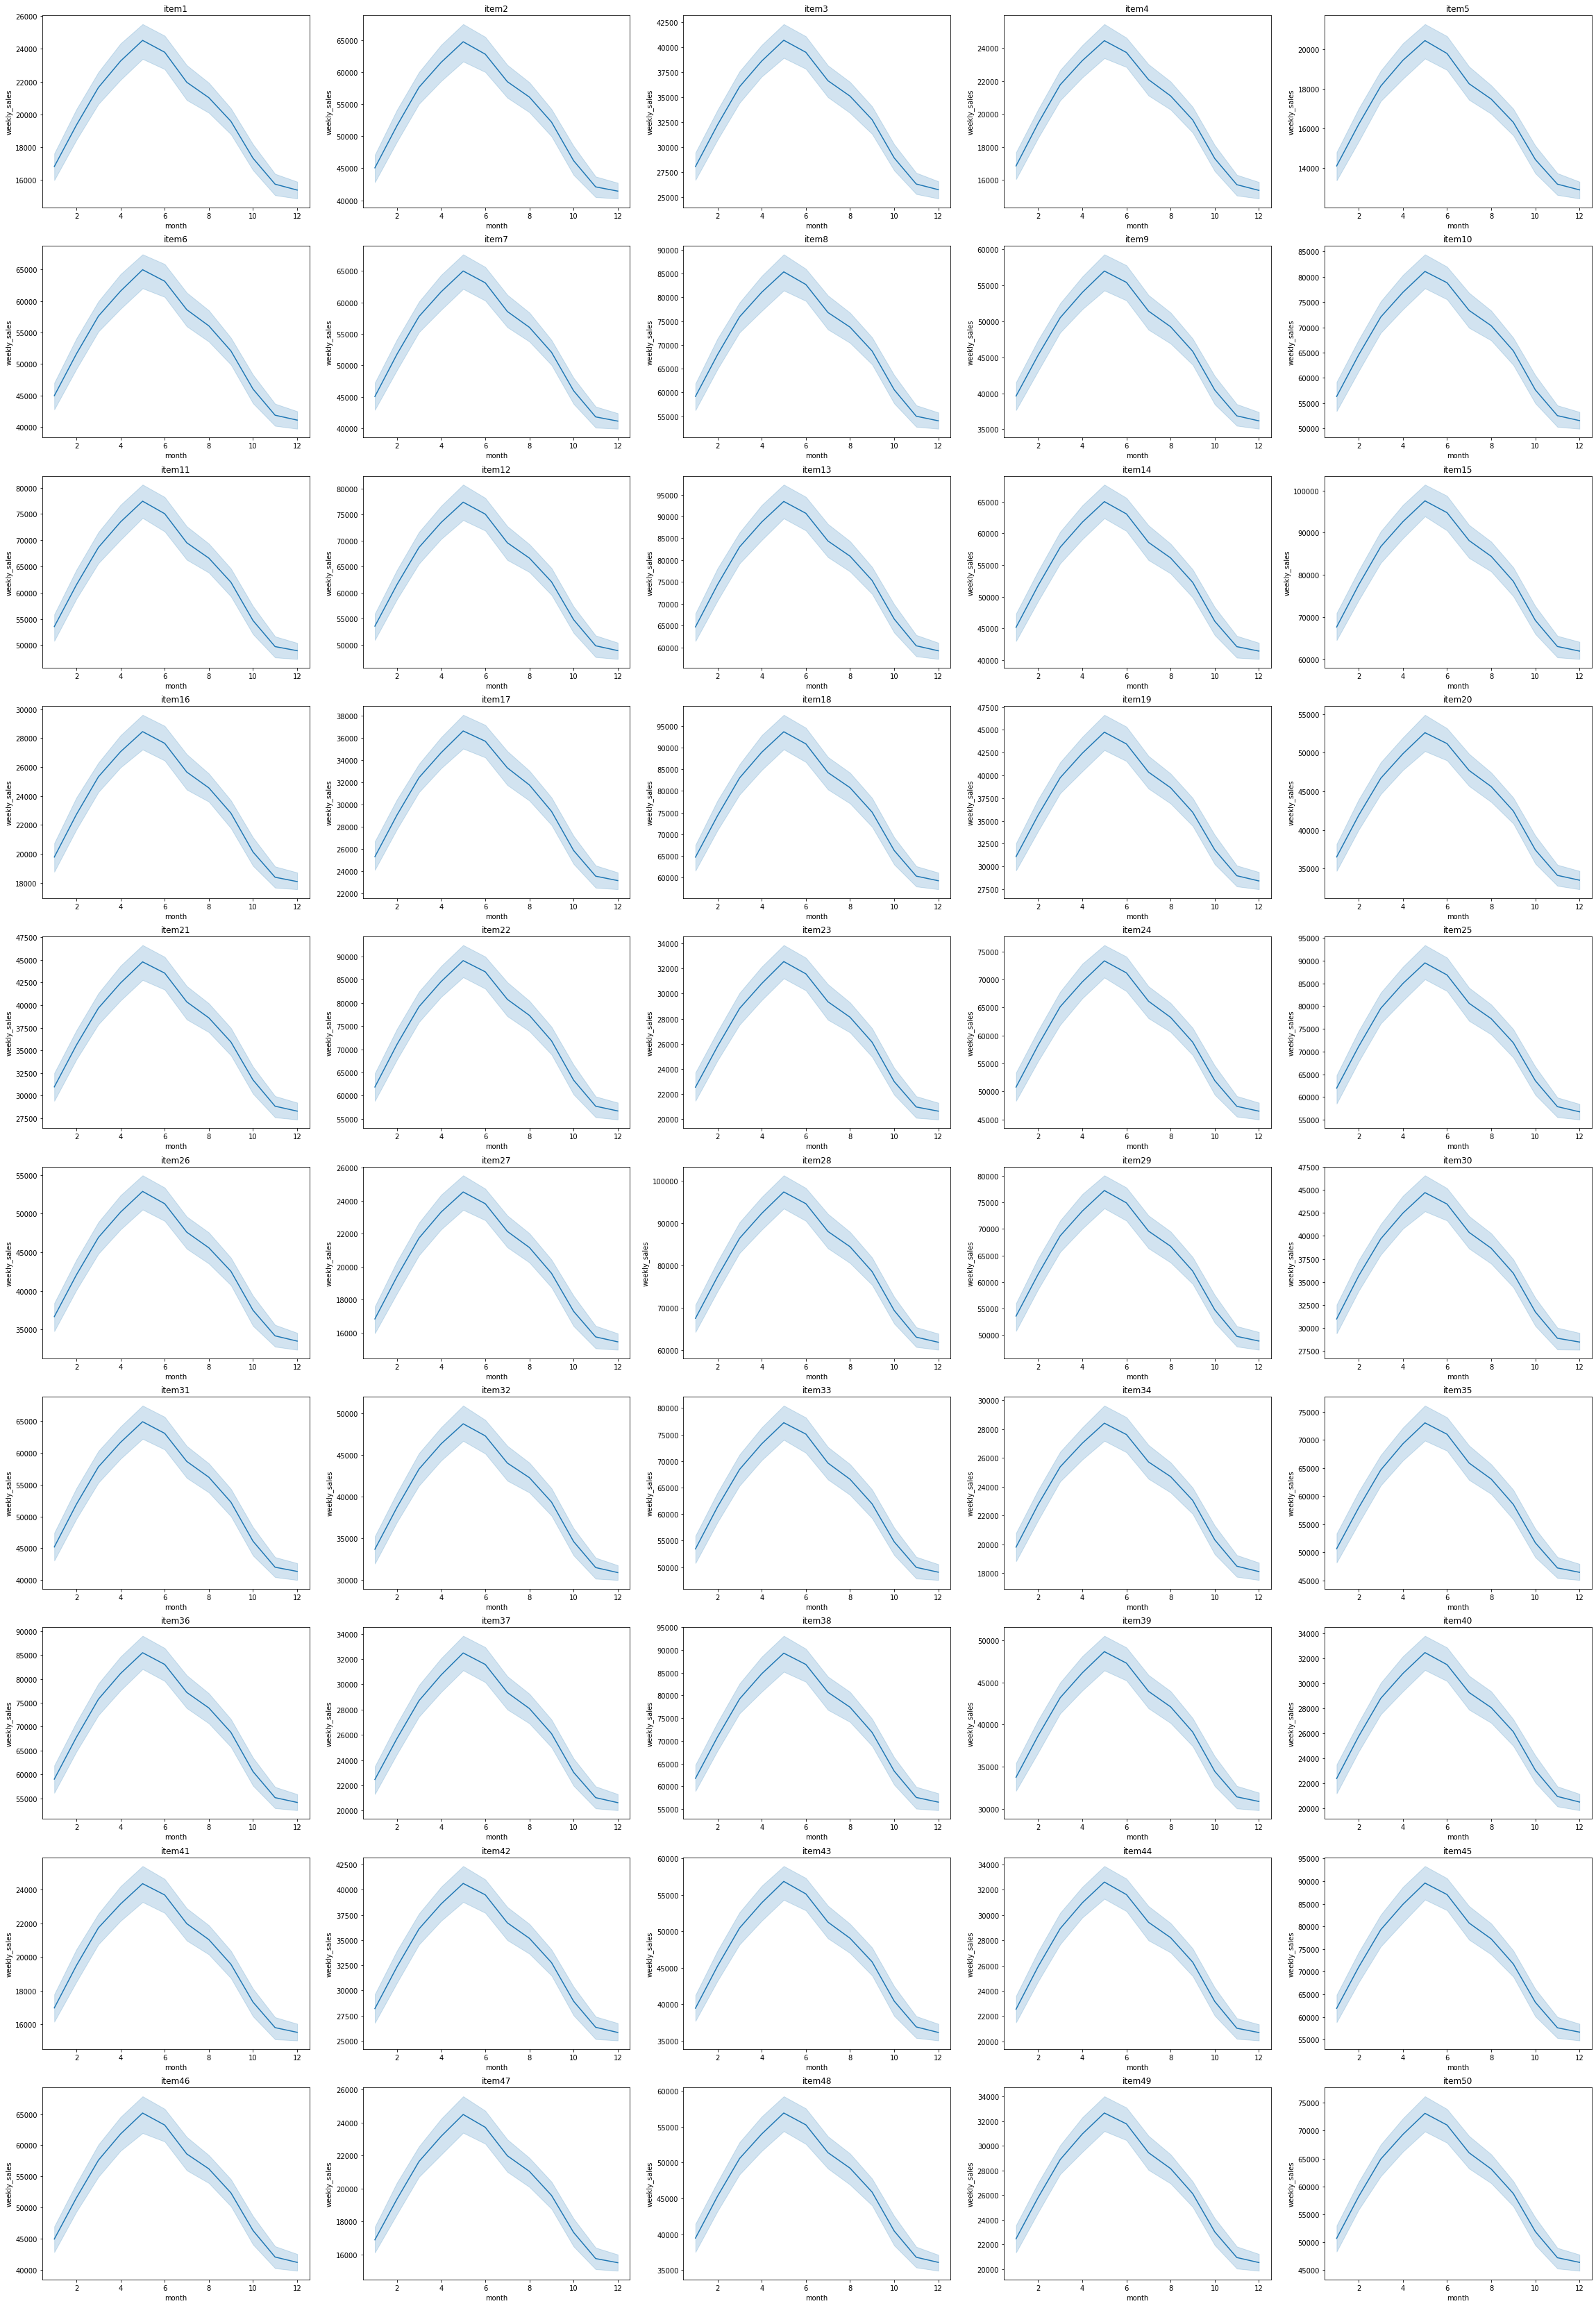

In [117]:
"""
here we are plot the each item in df_week based on month sales 
"""
fig, axes = plt.subplots(10, 5, figsize = (40,60))

for i in range(50):
  sns.lineplot(ax = axes[int(i/5),i%5], data = df_week[df_week['item'] == i+1 ], x = 'month', y = 'weekly_sales')
  axes[int(i/5),i%5].set_title('item' + str(i+1))

from above plot we can see that it is a seasonal data it increases upto 4 to 5th  months and  decreases  from 5th month

In [118]:
df_week.dtypes # check datatypes of the data

item                     int64
date            datetime64[ns]
weekly_sales             int64
year                     int64
day                      int64
quarter                  int64
month                    int64
dtype: object

In [119]:
df_week.drop('date',axis = 1,inplace = True) #  here we are droping the date column from the dataframe as we have taken all instance from the date column

In [120]:
# segregate  the dataframe into train ,validate and test based on year column
train_data = df_week.loc[(df_week["year"] <=2015)]
val_data = df_week.loc[(df_week["year"] == 2016), :]
test_data = df_week.loc[(df_week["year"] == 2017)]

In [121]:
# spliting the data
X_train = train_data.drop(columns = ['weekly_sales'])
Y_train = train_data['weekly_sales']

val_train = val_data.drop(columns = ['weekly_sales'])
val_test = val_data ['weekly_sales']

x_test = test_data.drop(columns = ['weekly_sales'])
y_test = test_data['weekly_sales']

In [122]:
X_train.shape,Y_train.shape,val_train.shape,val_test.shape

((7850, 5), (7850,), (2600, 5), (2600,))

# Modelling

For Modelling part we are using the light GBM model where are using the Randomizedsearch for hyper-parameter tunning and using the timeseriessplit for crosvalidation 

In [123]:
#hyper parameters for lightGBM
lgbm_params ={ "num_leaves": [10,15,20,30],
              "learning_rate": [0.1, 0.05, 0.02],
              "colsample_bytree":[0.5, 0.8, 1.0],
              "max_depth": [5, 7, 10, 20],
             }

In [124]:
# calling the model
model = lgb.LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=3)
rsearch2 = RandomizedSearchCV(model, lgbm_params, cv=tscv, verbose = True, n_jobs = -1).fit( X_train, Y_train ) # fitting the model

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [125]:
rsearch2.best_params_ # finding the best parameters

{'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 10,
 'num_leaves': 20}


 # LightGBM Model

Using this best parameter from RandomizedSearchCV we are constructing the model 

In [137]:
parameters = {'metric': 'root_mean_squared_error',
              'boosting': 'gbdt',
              'num_leaves': 20,
              'feature_fraction': 0.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 20,
              'max_depth': 10,
              'learning_rate': 0.02,
              'verbose': -1
             }

In [138]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train) # loading the dataset into model for training
lgbval = lgb.Dataset(data=val_train, label=val_test) # loading the validation dataset

"""
here we are training the model with parameter and with train and validation dataset and 
using the number of bossting rounds 1000 and stop at maximum 50% more in  early stopping round"""

model_lgbm = lgb.train(parameters,
                            lgbtrain,
                            valid_sets=lgbval,
                            num_boost_round=2000,
                            early_stopping_rounds=50)

[1]	valid_0's rmse: 23537.4
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 23325.5
[3]	valid_0's rmse: 23283.8
[4]	valid_0's rmse: 23254.4
[5]	valid_0's rmse: 23195.4
[6]	valid_0's rmse: 23171.6
[7]	valid_0's rmse: 22966.4
[8]	valid_0's rmse: 22752.7
[9]	valid_0's rmse: 22700
[10]	valid_0's rmse: 22666.3
[11]	valid_0's rmse: 22458.1
[12]	valid_0's rmse: 22403.1
[13]	valid_0's rmse: 22383.3
[14]	valid_0's rmse: 22335.8
[15]	valid_0's rmse: 22130.8
[16]	valid_0's rmse: 22098.7
[17]	valid_0's rmse: 22053.4
[18]	valid_0's rmse: 22029.6
[19]	valid_0's rmse: 22006.7
[20]	valid_0's rmse: 21961.1
[21]	valid_0's rmse: 21917.6
[22]	valid_0's rmse: 21718.9
[23]	valid_0's rmse: 21525.7
[24]	valid_0's rmse: 21338.2
[25]	valid_0's rmse: 21155.6
[26]	valid_0's rmse: 21117.9
[27]	valid_0's rmse: 21075.2
[28]	valid_0's rmse: 21052.6
[29]	valid_0's rmse: 21031.3
[30]	valid_0's rmse: 20991.6
[31]	valid_0's rmse: 20812.7
[32]	valid_0's rmse: 20773.8
[33]	valid_0's rmse: 

In [139]:
# predicting the values for training and validtion
y_train_pred = model_lgbm.predict(X_train) 
y_valid_pred = model_lgbm.predict(val_train)

In [140]:
# printing the accuacy using the r2_score 
print("r2_score Train: {:.4f}\nr2_score Valid: {:.4f}".format(r2_score(Y_train, y_train_pred),
                                                    r2_score(val_test, y_valid_pred)))

r2_score Train: 0.9941
r2_score Valid: 0.9389


# Feature importance

Text(0, 0.5, 'Feature Importance Score')

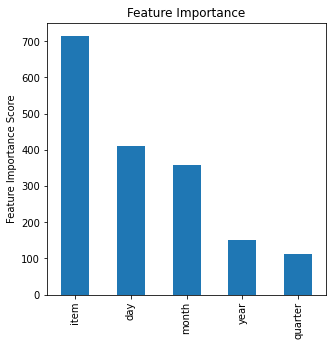

In [142]:
# mapping the feature importance
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(rsearch2.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 5, 5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

# Final Model

In [143]:
#predicting for the test data 
predict = model_lgbm.predict(x_test)

In [144]:
predict # values

array([15027.46129511, 15998.47503223, 17533.86033171, ...,
       58823.73002213, 59049.77468125, 54329.68084921])

In [145]:
r2_score(y_test, predict)

0.8852359764167002

In [150]:
df1 = test_data 

In [154]:
p = predict.astype(int) # we are converting this values from float to int as sales are in int datatype
df1['predict_sales'] = p # appending the values to dataframe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [155]:
df1 # printing dataframe

,item,weekly_sales,year,day,quarter,month,predict_sales
209,1,17715,2017,3,1,1,15027
210,1,18366,2017,10,1,1,15998
211,1,18990,2017,17,1,1,17533
212,1,19656,2017,24,1,1,19105
213,1,20344,2017,31,1,1,19925
...,...,...,...,...,...,...,...
12445,50,68007,2017,5,3,9,60677
12446,50,66445,2017,12,3,9,60109
12447,50,64902,2017,19,3,9,58823
12448,50,63360,2017,26,3,9,59049


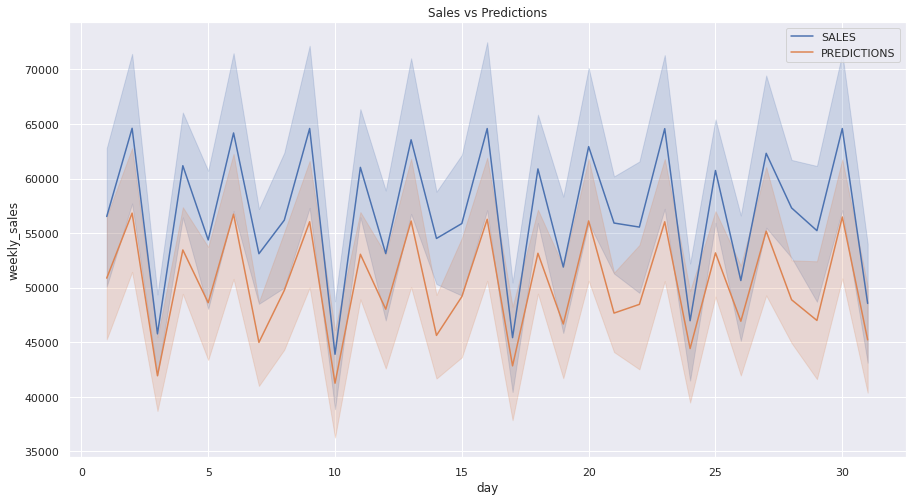

In [171]:
plt.figure(figsize=(15, 8))
plt.title("Sales vs Predictions")

sns.lineplot( x='day', y='weekly_sales', data=df1, label='SALES' )
sns.lineplot( x='day', y='predict_sales', data=df1, label='PREDICTIONS' )

plt.show()

So From above by comparing the sales with predict sales we can see that it predicts 80%  accurately.